In [1]:
import utils
import models
import PreciseSolutions

import numpy as np
import matplotlib.pyplot as plt

# Описание начальных условий

## Разрывное НУ

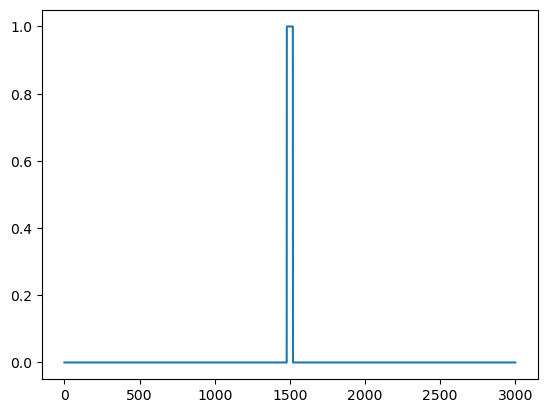

In [2]:
def impuls(x):
    if x < 1480 or x > 1520:
        return 0
    else:
        return 1

x = np.linspace(0, 3000, 3001)
y = np.array([impuls(xx) for xx in x])

plt.plot(x, y);

## Непрерывное НУ

(1400.0, 1600.0)

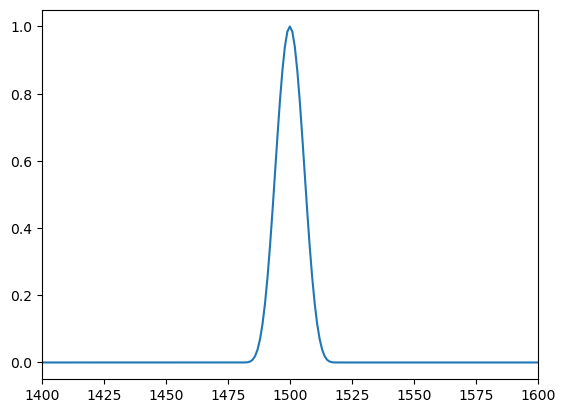

In [3]:
def halfsinus(x):
    m = 5
    if x < 1480 or x > 1520:
        return 0
    else:
        return np.sin(((x - 1480) * np.pi) / 40) ** m

x = np.linspace(0, 3000, 3001)
y = np.array([halfsinus(xx) for xx in x])

plt.plot(x, y);
plt.xlim(1400, 1600)

# Параметры задачи

In [4]:
TOTAL_TIME = 100
SPEED = 1

XLEFT = 0
XRIGHT = 3000

# Конкретный пример на одной сетке

In [5]:
mesh1 = models.Mesh(XLEFT, XRIGHT, N=3001)

In [7]:
def uniform_speed(mesh, U):
    return np.ones_like(mesh.xnodes) * SPEED

def zero_rightfunc(mesh, t, U):
    return np.zeros_like(mesh.xnodes)

In [25]:
task_params = models.TaskParams(halfsinus, uniform_speed, zero_rightfunc)

In [26]:
U_num_solution, time_steps = utils.main_runner(
    task_params, mesh1, Cu=1.0, total_time=TOTAL_TIME,
    time_step_method="Euler-1", space_deriv_approx_method="Backward", N_iter_max=int(1e5))

  0%|          | 100/100000 [00:00<00:18, 5340.00it/s]


In [27]:
U_prec_solution = PreciseSolutions.transport_eq_solution(task_params.init_cond, mesh1, SPEED, TOTAL_TIME)

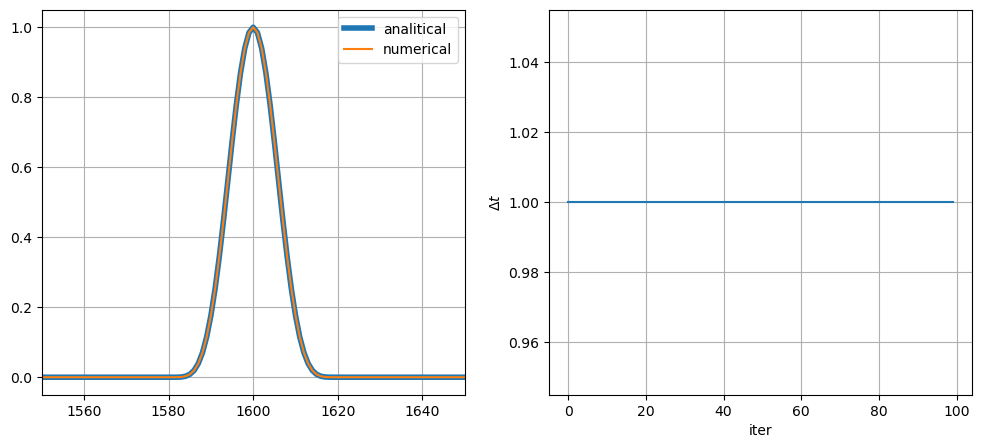

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

ax[0].plot(mesh1.xnodes, U_prec_solution, linewidth=4, label="analitical")
ax[0].plot(mesh1.xnodes, U_num_solution, label="numerical")

ax[0].legend()
ax[0].set_xlim(1550, 1650)
ax[0].grid()


ax[1].plot(time_steps)
ax[1].grid()
ax[1].set_xlabel("iter")
ax[1].set_ylabel("$\Delta t$")

plt.show()

# Исследование сходимости

In [39]:
TOTAL_TIME = 100
SPEED = 1

XLEFT = 0
XRIGHT = 3000

In [80]:
mesh2 = models.Mesh(XLEFT, XRIGHT, N=3001)
mesh1 = mesh2.get_twice_grid()
mesh0 = mesh1.get_twice_grid()
mesh00 = mesh0.get_twice_grid()

meshes_kw = {
    "mesh2" : mesh2,
    "mesh1" : mesh1,
    "mesh0" : mesh0,
    "mesh00" : mesh00,
}

In [42]:
print(mesh2.N)
print(mesh1.N)
print(mesh0.N)

3001
6001
12001


In [70]:
Cu = 0.1
N_iter_max = int(1e10)

task_params = models.TaskParams(halfsinus, uniform_speed, zero_rightfunc)

analitical_solutions = {
    "mesh2" : PreciseSolutions.transport_eq_solution(task_params.init_cond, mesh2, SPEED, TOTAL_TIME),
    "mesh1" : PreciseSolutions.transport_eq_solution(task_params.init_cond, mesh1, SPEED, TOTAL_TIME),
    "mesh0" : PreciseSolutions.transport_eq_solution(task_params.init_cond, mesh0, SPEED, TOTAL_TIME),
}

In [86]:
time_step_methods_list = []
time_step_methods_list += ["Euler-1"]
time_step_methods_list += ["Euler-2"]


space_deriv_approx_methods_list = []
# space_deriv_approx_methods_list += ["Forward"]
space_deriv_approx_methods_list += ["Backward"]

mesh_list = []
mesh_list += ["mesh2"]
mesh_list += ["mesh1"]
mesh_list += ["mesh0"]
mesh_list += ["mesh00"]

In [82]:
solutions_kw = dict()
for time_step_method in time_step_methods_list:
    for space_deriv_approx_method in space_deriv_approx_methods_list:
        print(f"{time_step_method} + {space_deriv_approx_method}".center(40, "."))
        for mesh_name in mesh_list:
            print(f"\t{mesh_name}:")
            mesh = meshes_kw[mesh_name]
            U_num_solution, time_steps = utils.main_runner(
                task_params, mesh, Cu, TOTAL_TIME, time_step_method, 
                space_deriv_approx_method, N_iter_max)
            solutions_kw[(time_step_method, space_deriv_approx_method, mesh_name)] = U_num_solution

...........Euler-1 + Backward...........
	mesh2:


  0%|          | 1001/10000000000 [00:00<342:40:45, 8106.05it/s]


	mesh1:


  0%|          | 2001/10000000000 [00:00<403:22:00, 6886.48it/s]


	mesh0:


  0%|          | 4000/10000000000 [00:00<599:01:35, 4637.15it/s]


	mesh00:


  0%|          | 8000/10000000000 [00:02<976:04:21, 2845.87it/s] 


...........Euler-2 + Backward...........
	mesh2:


  0%|          | 1001/10000000000 [00:00<631:43:21, 4397.15it/s]


	mesh1:


  0%|          | 2001/10000000000 [00:00<835:46:29, 3323.60it/s]


	mesh0:


  0%|          | 4000/10000000000 [00:01<1201:28:15, 2311.98it/s]


	mesh00:


  0%|          | 8000/10000000000 [00:06<2156:54:29, 1287.85it/s]


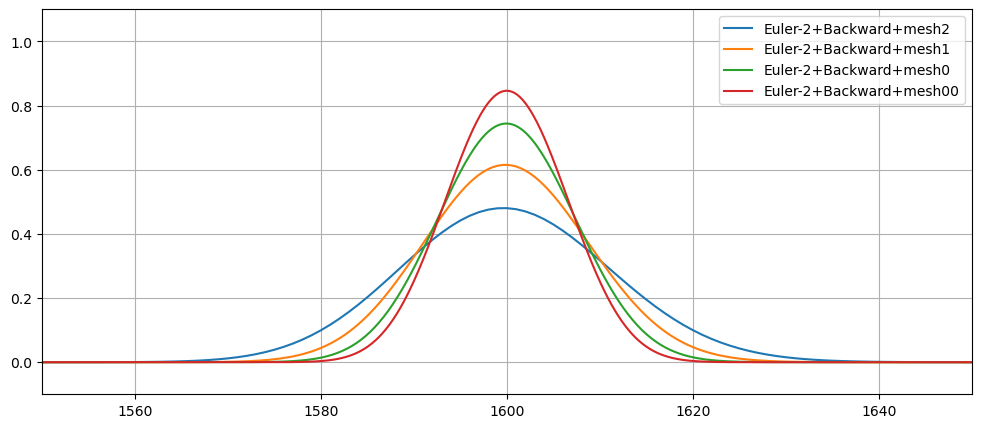

In [87]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))

for time_step_method in time_step_methods_list:
    for space_deriv_approx_method in space_deriv_approx_methods_list:
        for mesh_name in mesh_list:
            mesh = meshes_kw[mesh_name]
            U_num = solutions_kw[(time_step_method, space_deriv_approx_method, mesh_name)]
            label = f"{time_step_method}+{space_deriv_approx_method}+{mesh_name}"
            ax.plot(mesh.xnodes, U_num, label=label)

ax.legend()
ax.set_xlim(1550, 1650)
ax.set_ylim(-0.1, 1.1)
ax.grid()
plt.show()

In [ ]:
errors_kw = {}
for time_step_method in time_step_methods_list:
    for space_deriv_approx_method in space_deriv_approx_methods_list:
        errors_kw[(time_step_method, space_deriv_approx_method)] = np.zeros((2, len(mesh_list)))
        for i, mesh_name in enumerate(mesh_list):
            mesh = meshes_kw[mesh_name]
            U_num = solutions_kw[(time_step_method, space_deriv_approx_method, mesh_name)]
            error = utils.get_error(U_num, analitical_solutions[mesh_name], mesh)
            
            errors_kw[(time_step_method, space_deriv_approx_method)][0, i] = mesh.dx
            errors_kw[(time_step_method, space_deriv_approx_method)][1, i] = error